In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

%matplotlib inline

/home/wedeueis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [6]:
print("Size of: ")
print("- Training set:\t\t{}".format(len(data.train.labels)))
print("- Test set:\t\t{}".format(len(data.test.labels)))
print("- Validation set:\t{}".format(len(data.validation.labels)))


Size of: 
- Training set:		55000
- Test set:		10000
- Validation set:	5000


In [7]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [8]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [9]:
img_size = 28

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_classes = 10

In [14]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

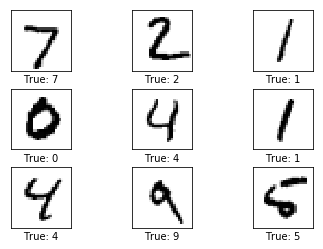

In [15]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images, cls_true=cls_true)

## Placeholders for data

In [24]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

y_true = tf.placeholder(tf.float32, [None, num_classes])

y_true_cls = tf.placeholder(tf.int64, [None])

In [25]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

biases = tf.Variable(tf.zeros([num_classes]))

## Computational graph

In [26]:
logits = tf.matmul(x, weights) + biases #model

In [27]:
y_pred = tf.nn.softmax(logits) #actvation function

In [28]:
y_pred_cls = tf.argmax(y_pred, axis=1) #predicted classes

## Optimization

In [30]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true) #error

In [31]:
cost = tf.reduce_mean(cross_entropy) #cost by averaging the cross entropy error

In [33]:
#setting up gradient descent
optmizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost) 

## Accuracy

In [34]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [35]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Execute calculations

In [36]:
session = tf.Session() # start session

In [37]:
session.run(tf.global_variables_initializer()) # initialize placeholdes feeding the data

In [38]:
batch_size = 100

## Optimization loop

In [39]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x:x_batch, y_true: y_true_batch}
        session.run(optmizer, feed_dict=feed_dict_train)

In [41]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

## Utility functions

In [42]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [78]:
def print_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks= np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [55]:
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)
    incorrect = (correct==False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

In [66]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    fig, axes = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i<10:
            image = w[:, i].reshape(img_shape)
            ax.set_xlabel("Weight: {0}".format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

## Performance before optimization

In [47]:
print_accuracy()

Accuracy on test-set: 9.8%


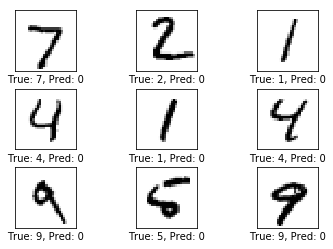

In [56]:
plot_example_errors()

## After 1 iteration (100 images)

In [58]:
optimize(num_iterations=1)

In [59]:
print_accuracy()

Accuracy on test-set: 48.3%


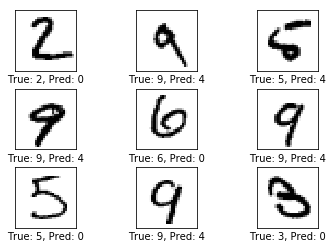

In [60]:
plot_example_errors()

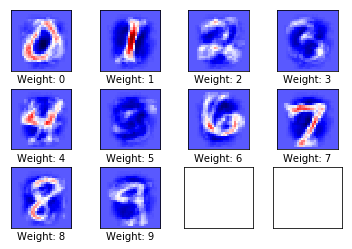

In [67]:
plot_weights()

## After 10 iteration (1000 images)

In [69]:
optimize(num_iterations=9)

In [70]:
print_accuracy()

Accuracy on test-set: 77.4%


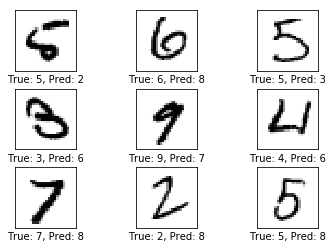

In [71]:
plot_example_errors()

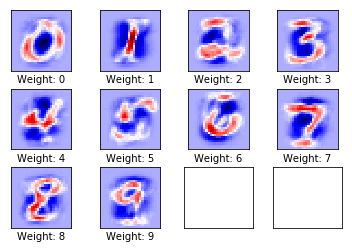

In [72]:
plot_weights()

## After 1000 iteration (100000 images)

In [82]:
optimize(num_iterations=990)

In [83]:
print_accuracy()

Accuracy on test-set: 92.0%


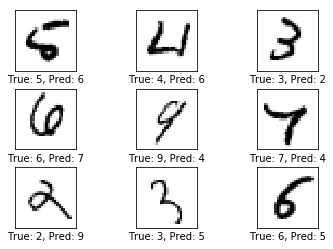

In [84]:
plot_example_errors()

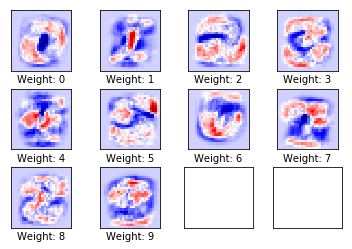

In [85]:
plot_weights()

[[ 961    0    2    4    0    3    5    3    2    0]
 [   0 1113    2    2    0    1    4    2   11    0]
 [   6   10  915   22    9    6   14   13   30    7]
 [   2    1   14  930    0   25    1   13   13   11]
 [   1    2    5    1  914    0    9    5    8   37]
 [   9    4    3   39   10  778   12    5   24    8]
 [  11    3    5    2    9   19  903    3    3    0]
 [   1    6   22    8    5    1    0  949    1   35]
 [   8   13    6   33    9   38    9   16  829   13]
 [  11    7    2    8   31    8    0   33    4  905]]


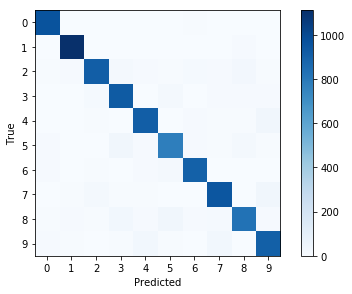

In [86]:
print_confusion_matrix()

In [87]:
session.close()